# Vision Tarea 11: Bordes de gradiente 

### Hacer la implementación que permita determinar los bordes de gradiente de una imagen dada en tono de gris. Reportar:
#### Daniel Castro Pineda 2220220H


In [59]:
import numpy as np
# from time import perf_counter
import cv2
import matplotlib.pyplot as plt
import numba as nb
import urllib.request


In [60]:
req = urllib.request.urlopen('https://upload.wikimedia.org/wikipedia/commons/thumb/b/bd/Taj_Mahal%2C_Agra%2C_India_edit3.jpg/640px-Taj_Mahal%2C_Agra%2C_India_edit3.jpg')
# req = urllib.request.urlopen(
    # 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/La_ic%C3%B3nica_caja_de_agua_del_acueducto_de_Morelia.jpg/1024px-La_ic%C3%B3nica_caja_de_agua_del_acueducto_de_Morelia.jpg')
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img = cv2.imdecode(arr, -1)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


In [61]:

def GKernel(sigma):
  m = int(np.floor(3*sigma + 0.5))
  N = int(2*m+1)
  g = np.zeros(N)

  suma = 0
  for n in range(1, m+1):
    g[m+n] = np.exp(- n**2 / (2*sigma**2))
    suma += g[m+n]

  suma = 1 + 2*suma

  for n in range(1, m+1):
    g[m+n] /= suma
    g[m-n] = g[m+n]
  g[m] = 1/suma

  return g


def GDerivadasKernel(sigma=1, orden=0):
  """ 
  Args:
  simga int , orden 1-7
  Retorna: gausiana por n orden de derivada 
   """
  if orden >= 0 and orden < 7:
    g = GKernel(sigma)
    gz = g.size
    mu = int(np.floor(3*sigma + 0.5))
    a = np.zeros(g.size)
    if (orden == 0):
      return g
    if (orden == 1):
      return [g[x]*(mu - x)/sigma**2 for x in range(gz)]
    if (orden == 2):
      return [g[x]*(((mu-x)**2 - sigma ** 2)/sigma**4) for x in range(gz)]
    if (orden == 3):
      return [g[x]*(3*sigma**2*(x - mu) - (x - mu)**3)/sigma**6 for x in range(gz)]
    if (orden == 4):
      return [g[x]*(3*sigma**4 - 6*sigma**2*(x - mu)**2 + (x - mu)**4)/sigma**8 for x in range(gz)]
    if (orden == 5):
      return [g[x]*(10*sigma**2*(x - mu)**3 + 15*sigma**4*(mu - x) - (x - mu)**5)/sigma**10 for x in range(gz)]
    if (orden == 6):
      return [g[x]*(-15*sigma**6 - 15*sigma**2*(x - mu)**4 + 45*sigma**4*(x - mu) + (x - mu)**6)/sigma**12 for x in range(gz)]
  else:
    raise Exception("Ingresar orden 1-7")


def convolveDesacopladaDot(img, kernelx, kernely):

    if(kernelx.size != kernely.size):
      raise Exception("Kernels deben ser del mismo tamaño")

    kernelx = np.flip(kernelx)
    kernely = np.flip(kernely)

    nrows, ncols = img.shape
    k_size = kernelx.size
    # krows, kcols = kernel.shape
    pad_size = (k_size - 1) // 2
    padded_img = np.pad(img, pad_size, mode='constant')
    # print(padded_img)
    output = np.zeros((nrows, ncols))

    output = np.array([convolveDot(img[i, :], kernelx) for i in range(nrows)])
    
    # print(output)
    output2 = np.zeros((nrows, ncols))
    output2 = np.array([convolveDot(output[:, j], kernely)
                       for j in range(ncols)]).T
    return output2



def convolveDot(signal, kernel):
    ker_size = kernel.size
    sig_size = signal.size
    # kernel = kernel[::-1]
    pad_size = (ker_size - 1) // 2
    padded_signal = np.pad(signal, pad_size, mode='constant')
    output = np.zeros(sig_size)
    output = [np.dot(padded_signal[k:k+ker_size], kernel)
              for k in range(sig_size)]

    return output


## a) La función para calcular los bordes de gradiente utilizando derivadas de Gassianas. La función recibirá como datos la imagen en tono de gris y la varianza de la gaussiana.

In [62]:
def bordesGaussiana(img, sigma):
    """ Calcula bordes de una imagen usando derivadas gaussianas de imagenes
    Args:
    img: imagen en tono de gris
    sigma: varianza de la gaussiana
    """
    d1 = np.array(GDerivadasKernel(sigma, 1))
    d0 = np.array(GDerivadasKernel(sigma, 0))
    imgx = convolveDesacopladaDot(img, d1, d0)
    imgy = convolveDesacopladaDot(img, d0, d1)
    grad = np.sqrt(imgx**2 + imgy**2)
    return grad


In [63]:

def caja(intImg, r, c, n, m):
    N = 2*n+1
    M = 2*m+1
    pad = (N - 1) // 2

    nrows, ncols = intImg.shape

    r0 = r - pad
    c0 = c - pad
    r1 = r + pad
    c1 = c + pad

    if r1 >= nrows:
        r1 = nrows - 1
    if c1 >= ncols:
        c1 = ncols - 1

    s0 = intImg[r1, c1]
    s1 = 0
    s2 = 0
    s3 = 0

    if r0 > 0:
        s1 = intImg[r0-1, c1]
    if c0 > 0:
        s2 = intImg[r1, c0-1]
    if r0 > 0 and c0 > 0:
        s3 = intImg[r0-1, c0-1]
    out = s0 - s1 - s2 + s3
    return out/(N)

def integralImg(img):
    nr = img.shape[0]
    nc = img.shape[1]
    intImg = np.zeros((nr, nc))

    a = np.array([np.cumsum(img[:, j]) for j in range(nc)]).T
    b = np.array([np.cumsum(a[i, :]) for i in range(nr)])
    intImg = b
    return intImg


def derivaintegral(img, tamCaja, dir):
    
    intimg = integralImg(img)
    nr, nc = img.shape
    out = np.zeros((nr, nc), dtype=np.float64)

    if dir == 'x':
        out = np.array([[
            caja(intimg, r, c+tamCaja, tamCaja, tamCaja) -
            caja(intimg, r, c-tamCaja, tamCaja, tamCaja)
            for c in range(nc)]
            for r in range(nr)
        ])

    if dir == 'y':
        out = np.array([[
            caja(intimg, r+tamCaja, c, tamCaja, tamCaja) -
            caja(intimg, r-tamCaja, c, tamCaja, tamCaja)
            for c in range(nc)]
            for r in range(nr)
        ])
    return out


## b) La función para calcular los bordes de gradiente utilizando derivadas con Imágenes integrales. La función recibirá como datos la imagen en tono de gris y el tamaño de las cajas involucradas.

In [64]:
def bordesIntegral(img, caja):
    """ Calcula bordes de una imagen usando integrales de imagenes
    Args:
    img: imagen en tono de gris
    caja: tamaño de la caja para calcular la derivada (2n+1, 2m+1)
    """
    imgx = derivaintegral(img, caja, 'x')
    imgy = derivaintegral(img, caja, 'y')
    grad = np.sqrt(imgx**2 + imgy**2)
    return grad

## c) Mostrar los resultados comparativos para la imagen dada. Mostrar la imagen los bordes de gradiente con derivadas de Gaussianas y las derivadas con imágenes integrales. Considerar que la varianza es sigma = 0.7 y el tamaño de la caja es 3x3.

In [65]:
bordesG = bordesGaussiana(gray, 0.7)
bordesG = cv2.normalize(bordesG, None, alpha=0, beta=255,
                        norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)


bordesIntegral = bordesIntegral(gray, 1)
bordesIntegral = cv2.normalize(
    bordesIntegral, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)


/var/folders/hs/q_d_445d1x1173_zp50_lv3w0000gn/T/ipykernel_66817/3630702426.py:29: RuntimeWarning: overflow encountered in ulong_scalars
  out = s0 - s1 - s2 + s3


### Bordes de gradiente utilizando derivadas de Gaussianas
$$ \sigma = 0.7 $$

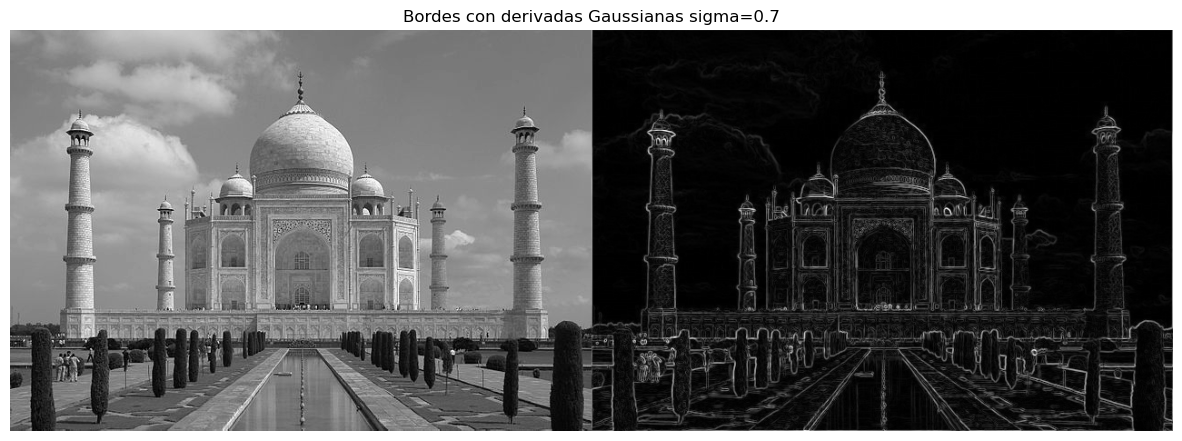

In [72]:

stack = np.hstack((gray, bordesG))

plt.figure(figsize=(15, 15))
plt.title('Bordes con derivadas Gaussianas sigma=0.7')
plt.imshow(stack, cmap='gray')
plt.axis('off')
plt.show()


### Bordes de gradiente utilizando derivadas con Imágenes integrales 
$$ caja = 3 \times 3$$

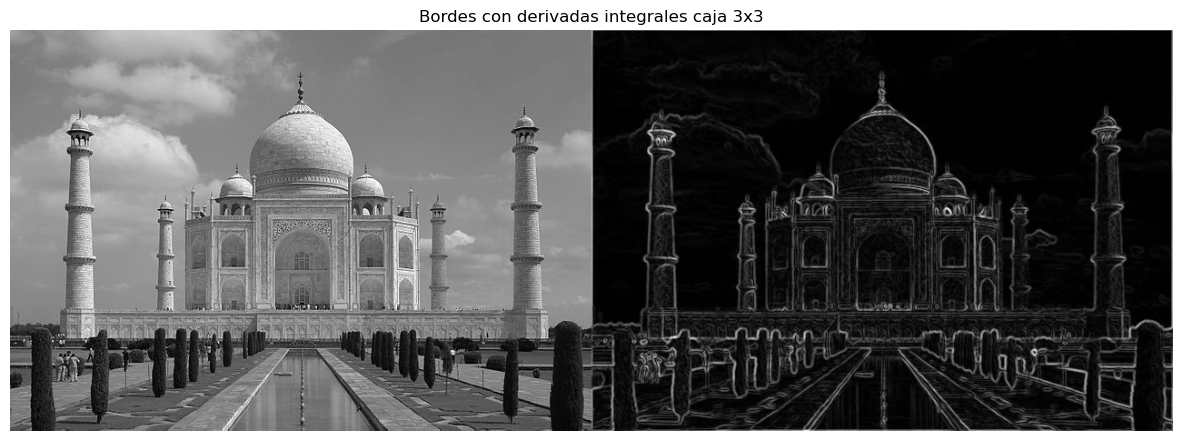

In [67]:

stack = np.hstack((gray, bordesIntegral))

plt.figure(figsize=(15, 15))
plt.title('Bordes con derivadas integrales caja 3x3')
plt.imshow(stack, cmap='gray')
plt.axis('off')
plt.show()

## d) Comparar los resultados de los incisos anteriores con la función de Canny de opencv.

In [68]:
imgCanny = cv2.Canny(gray, 200 , 100)

### Comparativa entre Bordes de gradiente utilizando derivadas de Gaussianas y Canny de OpenCV

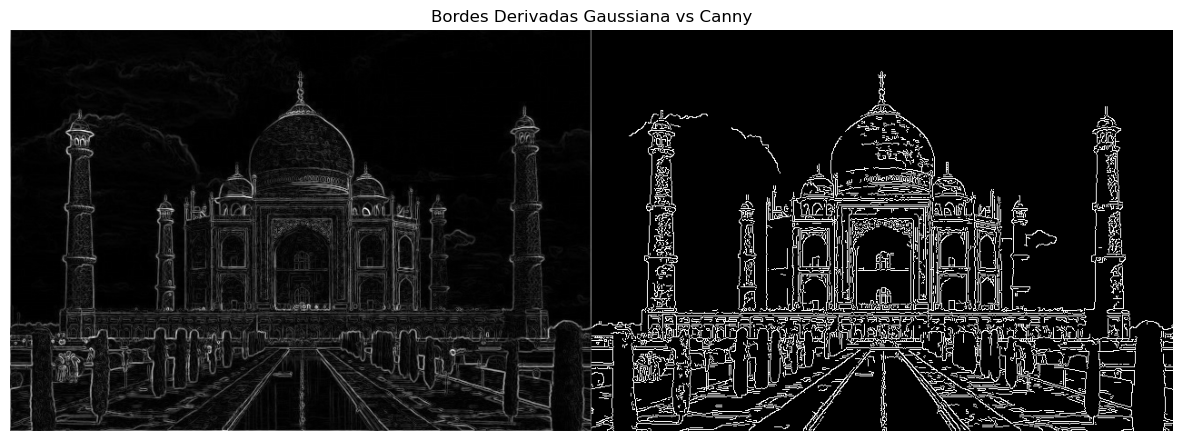

In [69]:

stack = np.hstack((bordesG, imgCanny))

plt.figure(figsize=(15, 15))
plt.title('Bordes Derivadas Gaussiana vs Canny')
plt.imshow(stack, cmap='gray')
plt.axis('off')
plt.show()


### Comparativa entre bordes de gradiente utilizando imágenes integrales y Canny de OpenCV

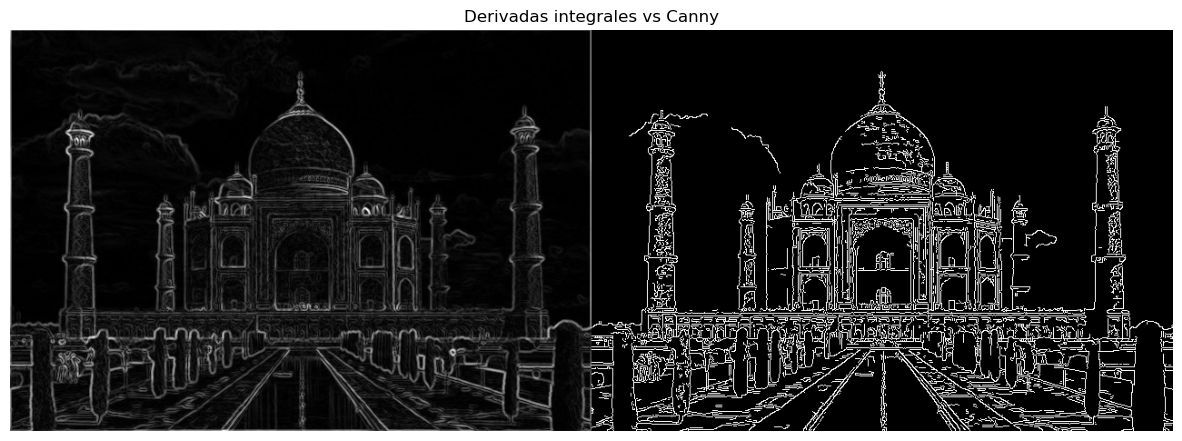

In [70]:
stack = np.hstack((bordesIntegral, imgCanny))

plt.figure(figsize=(15, 15))
plt.title('Derivadas integrales vs Canny')
plt.imshow(stack, cmap='gray')
plt.axis('off')
plt.show()
